# 特徵分析 文章標題
1. 透過 WordCloud 觀察文章標題的關鍵字分布 與 Label 之間的關係
2. 透過 NLP Model 分析文章標題的情緒分析

## 基本 Import 套件下載
特別 import NCHU_nlptoolkit 這個工具，這個工具相比一般的 jieba 能辨識最新的中文斷詞。

In [1]:
!pip install pandas
!pip install NCHU_nlptoolkit
!pip install sklearn
!pip install numpy
!pip install wordcloud
!pip install opencv-python
!pip install -U matplotlib
!pip install transformers
!pip install torch

In [2]:
import pandas as pd
import numpy as np
from NCHU_nlptoolkit.cut import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hank\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Hank\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Hank\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hank\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Building prefix dict from C:\Users\Hank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-pac

## 載入資料

In [17]:
df = pd.read_csv('../../raw_data/intern_homework_train_dataset.csv')
df.head()

,title,created_at,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,comment_count_1h,comment_count_2h,comment_count_3h,comment_count_4h,comment_count_5h,comment_count_6h,forum_id,author_id,forum_stats,like_count_24h
0,我的排骨湯,2022-10-05 14:20:21 UTC,12,15,15,15,16,18,10,10,10,10,10,10,598518,428921,0.7,26
1,#請益 婚禮穿搭,2022-10-05 14:28:13 UTC,0,0,3,4,4,4,2,5,8,9,9,9,399302,650840,63.9,11
2,無謂的啦啦隊,2022-10-06 07:18:22 UTC,3,7,8,11,12,14,1,1,2,3,3,3,650776,717288,19.2,19
3,文學理論 課本,2022-09-20 11:39:14 UTC,2,7,11,24,26,26,2,2,8,32,38,63,471023,173889,7.9,29
4,一般課程,2022-09-05 10:18:24 UTC,3,7,7,10,10,11,15,26,35,38,48,49,230184,594332,36.2,16


In [18]:
title = df['title']
target = df.pop('like_count_24h')

In [19]:
title[:25]

0                                               我的排骨湯
1                                            #請益 婚禮穿搭
2                                              無謂的啦啦隊
3                                             文學理論 課本
4                                                一般課程
5                                       籌辦迎新的學長姐們辛苦了！
6     ☁︎ ☾ ⋆ • ⋆ 小直徑月牙隱眼 Hapa Kristin Basic olive 橄欖色
7                                           藍天社-課後輔導營
8                                            海底撈店員很掃興
9                                     #分享 粉粉嫩嫩的暈染花美甲🌸
10                                            尋找遺失錢包！
11                                      #分享 Sabon快速開箱
12                                         是萬聖節不是感謝祭🎃
13                                         醫學系怎麼交到女朋友
14                                           嘉義大埔骨折小貓
15                             #分享 把握最後夏天的短褲機會😈露腿保養好物
16                                 #售票 周興哲演唱會門票 10/21
17                                          請益台中深夜咖啡廳
18               #分享 （已截止）上榜

## 透過 WordCloud 觀察文章標題的關鍵字分布 與 Label 之間的關係

### 針對 文章的標題 進行斷詞

### 範例 : 以 "今天天氣真好" 作為文章標題，進行斷詞

In [10]:
# Example
example_title = "今天天氣真好"
print('before tokenization, title = ',example_title)
print('after tokenization, token set =',set(cut_sentence(example_title, flag=True)))

before tokenization, title =  今天天氣真好
after tokenization, token set = {('天氣', 'N'), ('真好', 'd')}


### 將所有訓練資料的文章標題進行斷詞，並統計對應文章 (Label) 的愛心數

### 範例: 假設目前只有 2 篇文章
用 vocab dict 來統計 文章標題的關鍵字 與 文章24h後的愛心數

In [11]:
example1 = ["#分享 粉粉嫩嫩的暈染花美甲🌸",100]
example2 = ["#分享 Sabon快速開箱",50]
example_data =  [example1,example2]
vocab = dict()
for each_data in example_data:
    doc, score = each_data

    # 將文章標題斷詞
    tokens = set(cut_sentence(doc, flag=True))
    print('title = ',doc)
    print('tokens = ',tokens)

    # 斷詞後，會有 單字(t) 和 詞性(pos)
    for t,pos in tokens:
        if t in vocab:
            vocab[t].append(score)
        else:
            vocab[t] = [score]

title =  #分享 粉粉嫩嫩的暈染花美甲🌸
tokens =  {('美甲', 'Vi'), ('暈染', 'Vi'), ('嫩嫩', 'Vi'), ('花', 'Vt'), ('分享', 'Vt'), ('粉粉', 'N')}
title =  #分享 Sabon快速開箱
tokens =  {('bon', 'eng'), ('快速', 'Vi'), ('Sa', 'x'), ('分享', 'Vt'), ('開箱', 'Vi')}


用 res 來統計對應關鍵字，平均獲得的愛心數

In [12]:
## 平均 score
def Average(lst):
    return sum(lst) / len(lst)
res = list()
for token, scores in vocab.items():
    if len(token) > 1:
        res.append([token,Average(scores)])
res = sorted(res, key = lambda x : x[1],reverse=True)
print(res)

[['美甲', 100.0], ['暈染', 100.0], ['嫩嫩', 100.0], ['粉粉', 100.0], ['分享', 75.0], ['bon', 50.0], ['快速', 50.0], ['Sa', 50.0], ['開箱', 50.0]]


### 統計 train dataset title 關鍵字與對應的愛心數 (只考慮 名詞的情況下)

In [20]:
# 因為要做文字雲與關鍵字分析，我這邊只考慮名詞(N) 或的單字，如果考慮動詞會有 "殺害"、"爆打"、"痛毆"、"上吊"、"駕崩" 等字眼，
# jieba 對應詞性表 : https://blog.csdn.net/Yellow_python/article/details/83991967
vocab = dict()
pos_list = ["N","n"]
for doc,score in zip(title, target):
    # 將文章標題斷詞
    tokens = set(cut_sentence(doc, flag=True))
   
    # 斷詞後，會有 單字(t) 和 詞性(pos)
    for t,pos in tokens:
        if t in vocab and pos in pos_list:
            vocab[t].append(score)
        elif pos in pos_list:
            vocab[t] = [score]
def Average(lst):
    return sum(lst) / len(lst)
res = list()
for token, scores in vocab.items():
    if len(token) > 1:
        res.append([token,Average(scores)])
res = sorted(res, key = lambda x : x[1],reverse=True)

In [21]:
print('Top 10 熱門愛心數的文章標題關鍵字 = ',res[:10])

Top 10 熱門愛心數的文章標題關鍵字 =  [['肺癌', 8935.0], ['捐肝', 5171.0], ['大腸癌', 3646.0], ['腦部', 3646.0], ['車鈴', 3274.0], ['水泥車', 3187.0], ['上裝', 3015.0], ['哀悼期', 2766.0], ['萬事通', 2675.0], ['雷區', 2194.0]]


In [22]:
print('Top 11~20 熱門愛心數的文章標題關鍵字 = ',res[11:20])

Top 11~20 熱門愛心數的文章標題關鍵字 =  [['這七年', 2091.0], ['糖尿病', 2091.0], ['楊謹華', 2081.0], ['開關', 2051.0], ['金宇彬', 1850.0], ['留點', 1668.0], ['童屍', 1655.0], ['北宜', 1640.0], ['禮堂', 1629.0]]


### 建立文字雲，使用關鍵字和對應的 score 來當作文字雲的大小權重

In [23]:
res = dict(res)

In [25]:
from wordcloud import WordCloud
cloud = WordCloud(background_color='white',font_path="NotoSansTC-Regular.otf").generate_from_frequencies(res)

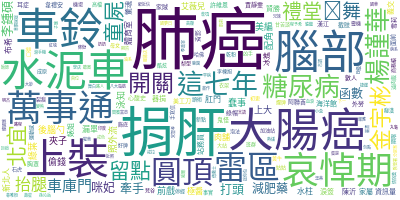

In [26]:
from IPython.display import Image, display
cloud.to_file('title_wordcloud.png')
display(Image('title_wordcloud.png'))

用 Dcard Logo 來當文字雲，先將 Dcard Logo 轉灰階，再用灰階圖片來做文字雲的 mask

轉灰階

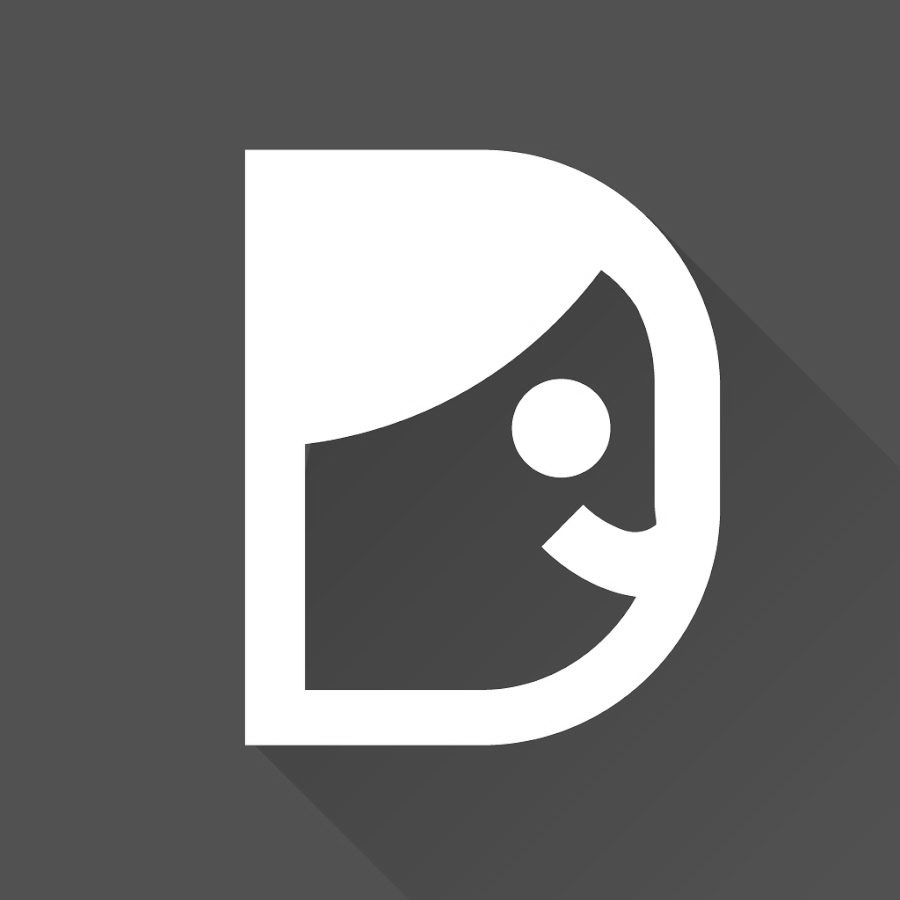

In [28]:
import cv2

image = cv2.imread('dcard.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('dcard_gray.png', image)
display(Image('dcard_gray.png'))

用灰階圖片來做 mask

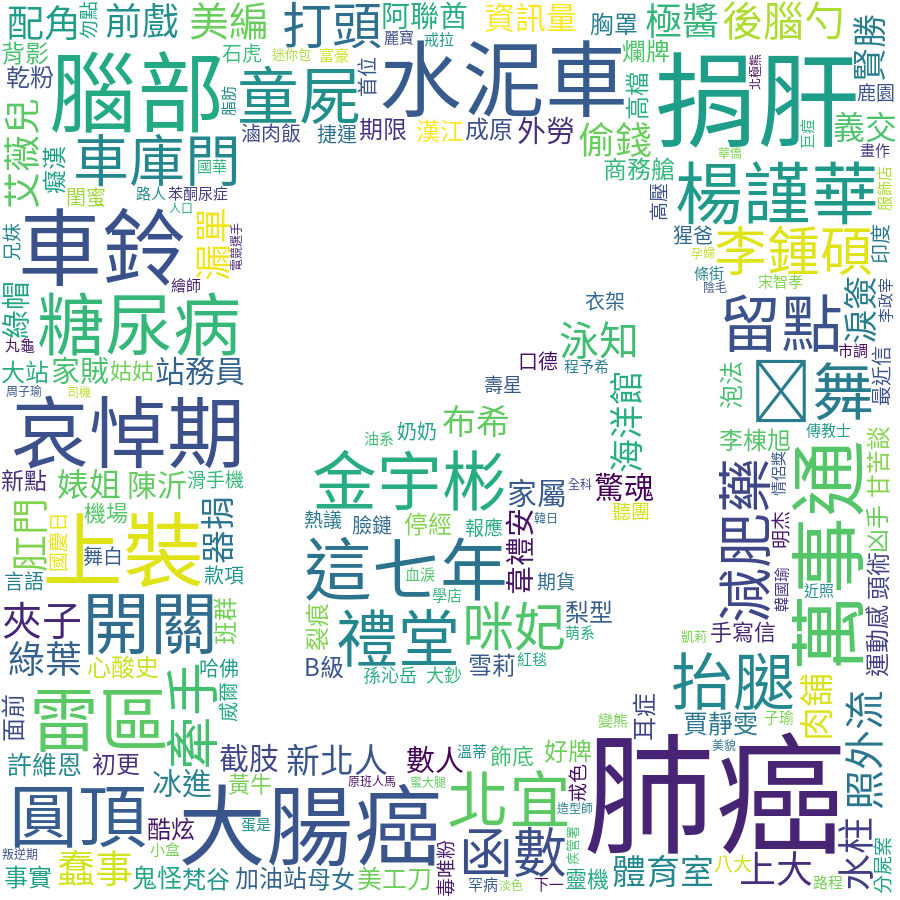

In [29]:
import numpy as np
cloud_mask=np.array(cv2.imread('dcard_gray.png'))
cloud = WordCloud(background_color='white',mask=cloud_mask,font_path="NotoSansTC-Regular.otf").generate_from_frequencies(res)
from IPython.display import Image, display
cloud.to_file('dcard_wordcloud.png')
display(Image('dcard_wordcloud.png'))

### 文字雲考慮 名詞和動詞 的情況下

In [30]:
# jieba 對應詞性表 : https://blog.csdn.net/Yellow_python/article/details/83991967
vocab = dict()
pos_list = ["N","n","v","Vt","Vi"]
for doc,score in zip(title, target):
    # 將文章標題斷詞
    tokens = set(cut_sentence(doc, flag=True))
   
    # 斷詞後，會有 單字(t) 和 詞性(pos)
    for t,pos in tokens:
        if t in vocab and pos in pos_list:
            vocab[t].append(score)
        elif pos in pos_list:
            vocab[t] = [score]
def Average(lst):
    return sum(lst) / len(lst)
res = list()
for token, scores in vocab.items():
    if len(token) > 1:
        res.append([token,Average(scores)])
res = sorted(res, key = lambda x : x[1],reverse=True)

In [31]:
print('Top 10 熱門愛心數的文章標題關鍵字 = ',res[:10])

Top 10 熱門愛心數的文章標題關鍵字 =  [['肺癌', 8935.0], ['捐肝', 5171.0], ['爆打', 4565.0], ['痛毆', 4565.0], ['大腸癌', 3646.0], ['腦部', 3646.0], ['暴怒', 3274.0], ['車鈴', 3274.0], ['按下', 3274.0], ['閃躲', 3187.0]]


In [32]:
print('Top 11~20 熱門愛心數的文章標題關鍵字 = ',res[11:20])

Top 11~20 熱門愛心數的文章標題關鍵字 =  [['狂奔', 3135.0], ['刮痧', 3040.0], ['上裝', 3015.0], ['哀悼期', 2766.0], ['上吊', 2729.5], ['萬事通', 2675.0], ['通緝', 2432.0], ['雷區', 2194.0], ['圓頂', 2154.0]]


建立文字雲

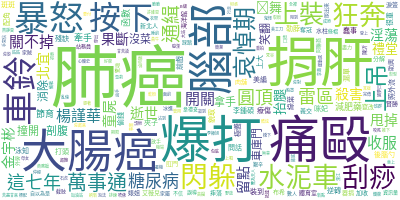

In [36]:
from wordcloud import WordCloud
res = dict(res)
cloud = WordCloud(background_color='white',font_path="NotoSansTC-Regular.otf").generate_from_frequencies(res)
from IPython.display import Image, display
cloud.to_file('title_wordcloud(考慮動詞).png')
display(Image('title_wordcloud(考慮動詞).png'))

Dcard Logo 文字雲

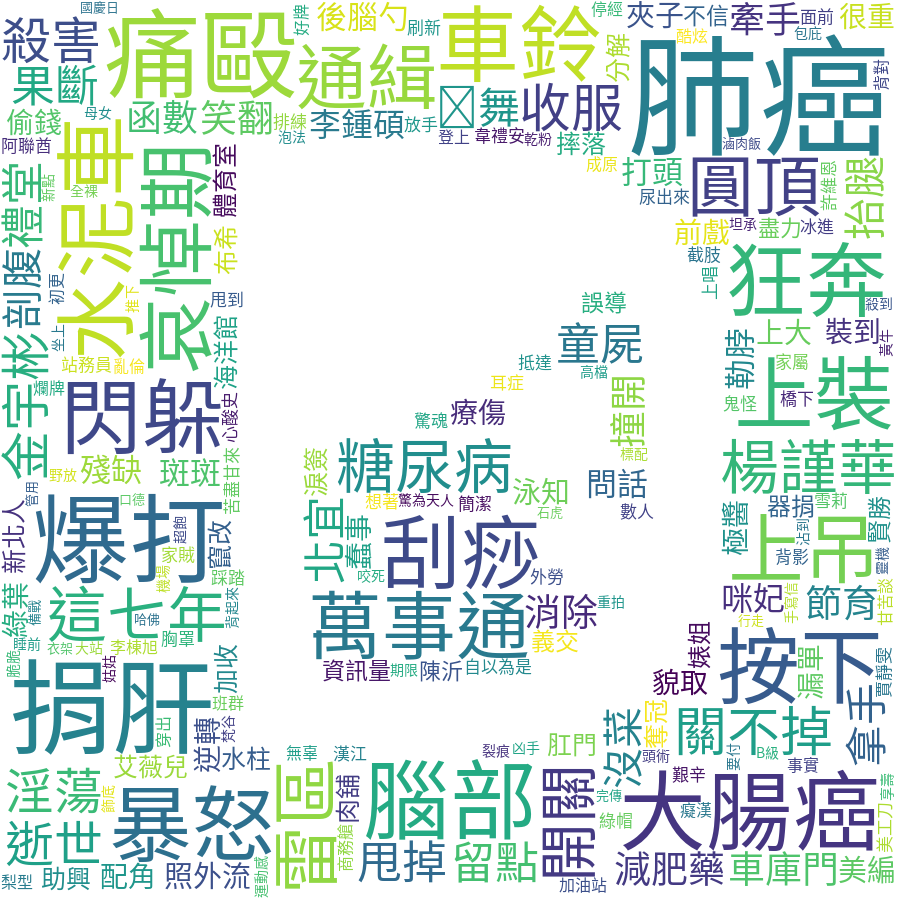

In [37]:
import numpy as np
cloud_mask=np.array(cv2.imread('dcard_gray.png'))
cloud = WordCloud(background_color='white',mask=cloud_mask,font_path="NotoSansTC-Regular.otf").generate_from_frequencies(res)
from IPython.display import Image, display
cloud.to_file('dcard_wordcloud(考慮動詞).png')
display(Image('dcard_wordcloud(考慮動詞).png'))

## 透過 NLP Model 分析文章標題的情緒分析

使用 HuggingFace 上已經 pretrained 好的模型進行情緒分析任務

模型連結 : https://huggingface.co/IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment?text=%E4%BB%8A%E5%A4%A9%E5%BF%83%E6%83%85%E4%B8%8D%E5%A5%BD

In [1]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch

tokenizer=BertTokenizer.from_pretrained('IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment')
model=BertForSequenceClassification.from_pretrained('IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment')

範例

In [12]:
text='今天心情不好'

output = model(torch.tensor([tokenizer.encode(text)]))
tensor_output = torch.nn.functional.softmax(output.logits,dim=-1)
prediction = "正面" if tensor_output.tolist()[0][1] > tensor_output.tolist()[0][0] else "負面"
print(tensor_output)
print(prediction)

tensor([[0.9551, 0.0449]], grad_fn=<SoftmaxBackward0>)
負面


In [13]:
text='今天心情真好'

output = model(torch.tensor([tokenizer.encode(text)]))
tensor_output = torch.nn.functional.softmax(output.logits,dim=-1)
prediction = "正面" if tensor_output.tolist()[0][1] > tensor_output.tolist()[0][0] else "負面"
print(tensor_output)
print(prediction)

tensor([[0.1658, 0.8342]], grad_fn=<SoftmaxBackward0>)
正面


### 針對累積愛心數最多的前25筆文章進行情緒分類任務

In [53]:
import pandas as pd
df = pd.read_csv('../../raw_data/intern_homework_train_dataset.csv')
title_df = df.loc[:, ['title', 'like_count_24h']]
title_df.head()

,title,like_count_24h
0,我的排骨湯,26
1,#請益 婚禮穿搭,11
2,無謂的啦啦隊,19
3,文學理論 課本,29
4,一般課程,16


In [54]:
title_df.sort_values(by=['like_count_24h'], ascending=False)[:25]

,title,like_count_24h
16289,英國女王逝世享耆壽96歲！,13297
5686,20歲我得了肺癌四期,8935
26951,男友忘記掛電話，讓我聽到噁心事實(已分手封鎖),7588
39049,：牽手走了64年 該放手了（更,7084
30193,家裡外勞懷孕了,5524
33416,三個月前14年閨蜜在我面前上吊，今天我最好的朋友被殺害,5450
35922,回台灣後發現高中同學成了我爸的小情人,5334
22475,21歲捐肝,5171
48096,＃更 分手後多久可以交下一任,4933
8921,我對奶奶講了很重的話,4903


將每筆的 title 文字透過 情緒分類模型 算出負面的數值，數值越趨近於 0 代表正面，越趨近於 1 代表負面

In [58]:
top_25 = title_df.sort_values(by=['like_count_24h'], ascending=False)[:25].values
negative_list = []
for title, score in top_25:
    output = model(torch.tensor([tokenizer.encode(title)]))
    tensor_output = torch.nn.functional.softmax(output.logits,dim=-1)
    negative_list.append(tensor_output.tolist()[0][0])
    
print(negative_list)

[0.5468915700912476, 0.990071177482605, 0.957534670829773, 0.3294329345226288, 0.31578493118286133, 0.3342750370502472, 0.37334299087524414, 0.7043811082839966, 0.6599180698394775, 0.9936488270759583, 0.7236841320991516, 0.07501419633626938, 0.7140719890594482, 0.1732184886932373, 0.07510852813720703, 0.880362868309021, 0.033510591834783554, 0.10281139612197876, 0.6572725772857666, 0.723463237285614, 0.8437601923942566, 0.00857364572584629, 0.02537677064538002, 0.9442314505577087, 0.9891201257705688]


使用 histogram 來觀察情緒分類的分布情況

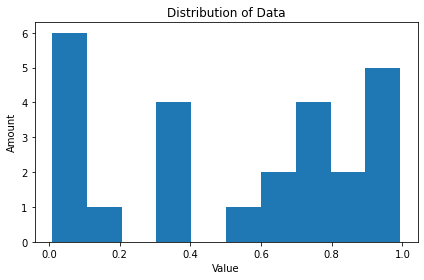

In [63]:
import numpy as np
import matplotlib.pyplot as plt


# 使用 matplotlib 的 histogram 函數來繪製資料的分布情況
plt.hist(negative_list, bins=10)
plt.xlabel('Value')
plt.ylabel('Amount')
plt.title('Distribution of Data')

# 將圖片存檔
fig = plt.gcf()
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig('histogram of title sentiment analysis.png')
plt.show()


<Figure size 432x288 with 0 Axes>